# Caveats, differences from main PWWB repo
- Bounding boxes are different. In other places it's: `-118.75, 33.5, -117.5, 34.5`, in others it's `33.6, 34.3, -118.6, -117.9`. I don't know why the differences are here, so I'll just use the later.

# Accessing the data
Using the AirNow API, we'll request a json of the data we need.

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

'''
date_start = '2025-01-10T00'
date_end = '2025-01-16T23'
airnow_api_key = print("YOU NEED TO ADD YOUR API KEY!")
URL = "https://www.airnowapi.org/aq/data"

# location given here

# defining a params dict for the parameters to be sent to the API
PARAMS = {
    'startDate':date_start,
    'endDate':date_end,
    'parameters':'PM25',
    'BBOX':'-118.75,33.5,-117.5,34.5',
    'dataType':'B',
    'format':'application/json',
    'verbose':'0',
    'monitorType':'2',
    'includerawconcentrations':'1',
    'API_KEY':airnow_api_key
}

# sending get request and saving the response as response object
response = requests.get(url = URL, params = PARAMS)

# extracting data in json format
airnow_data = response.json()
with open('airnow.json', 'w') as file:
    json.dump(airnow_data, file)
    print("JSON data saved to airnow.json")
df = pd.json_normalize(airnow_data)
display(df.head())
'''

print("Skip this portion after the first run.")

Skip this portion after the first run.


This should generate a URL like this:
```
https://www.airnowapi.org/aq/data/?startDate=2025-01-10T00&endDate=2025-01-16T23&parameters=PM25&BBOX=-118.6,33.6,-117.9,34.3&dataType=B&format=application/json&verbose=0&monitorType=2&includerawconcentrations=1&API_KEY=YOUR-API-KEY-HERE
```

You can also use a query tool from AirNow:
- https://docs.airnowapi.org/Data/query

In [16]:
# open json file and convert to dataframe
with open('airnow.json', 'r') as file:
    airnow_data = json.load(file)
airnow_df = pd.json_normalize(airnow_data)
airnow_df[0:20]

,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category
0,34.276320,-118.683690,2025-01-10T00:00,PM2.5,UG/M3,0.0,-1.0,0,1
1,34.199200,-118.533100,2025-01-10T00:00,PM2.5,UG/M3,2.9,1.2,16,1
2,34.383300,-118.528300,2025-01-10T00:00,PM2.5,UG/M3,2.1,2.1,12,1
3,34.181977,-118.363036,2025-01-10T00:00,PM2.5,UG/M3,60.5,53.2,155,4
4,34.066429,-118.226755,2025-01-10T00:00,PM2.5,UG/M3,55.3,50.4,150,3
5,33.901400,-118.205000,2025-01-10T00:00,PM2.5,UG/M3,21.6,12.2,74,2
6,33.793713,-118.171019,2025-01-10T00:00,PM2.5,UG/M3,21.6,10.8,74,2
7,33.830586,-117.938509,2025-01-10T00:00,PM2.5,UG/M3,36.6,40.0,104,3
8,34.143900,-117.850800,2025-01-10T00:00,PM2.5,UG/M3,26.3,23.7,83,2
9,34.276320,-118.683690,2025-01-10T01:00,PM2.5,UG/M3,0.0,-999.0,0,1


# Interpolate
- This seems to only work on one frame...? why doesn't the freaking training notebook have this code...????asdfjiishdfjkavhjk
- I believe i have to preprocess one frame at a time. the problem is, this json file has the data like... one pixel at a time i think? is each row a sensor? (i think yes. thre seem to be 9...? the docs aren't clear on how many sensors there are and where they are... this also means i'll have to update the convlstm model to output 8 sensors)
- also wtf is value vs aqi?? its not even on the docs https://docs.airnowapi.org/Data/docs like wtf

In [3]:
def preprocess_ground_sites(df, dim, latMax, latMin, lonMax, lonMin):
    latDist, lonDist = abs(latMax - latMin), abs(lonMax - lonMin)
    unInter = np.zeros((dim,dim))
    dfArr = np.array(df[['Latitude','Longitude','Value']])
    for i in range(dfArr.shape[0]):
        # Calculate x
        x = int(((latMax - dfArr[i,0]) / latDist) * dim)
        if x >= dim:
            x = dim - 1
        if x <= 0:
            x = 0
        # Calculate y
        y = dim - int(((lonMax + abs(dfArr[i,1])) / lonDist) * dim)
        if y >= dim:
            y = dim - 1
        if y <= 0:
            y = 0
        if dfArr[i,2] < 0:
            unInter[x,y] = 0
        else:
            unInter[x,y] = dfArr[i,2]
    return unInter

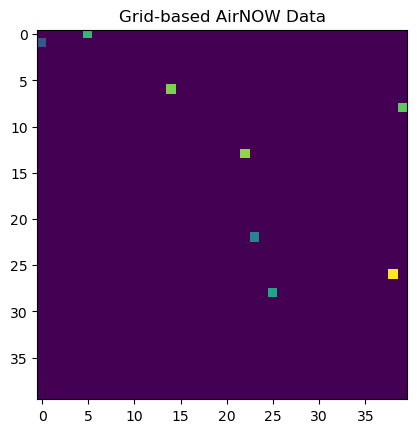

In [4]:
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
dim = 40

unInter = preprocess_ground_sites(airnow_df, dim, lat_top, lat_bottom, lon_top, lon_bottom)

plt.imshow(unInter)
plt.title("Grid-based AirNOW Data")
plt.show()

In [5]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

def interpolate_frame(f, dim):
    i = 0
    interpolated = []
    count = 0
    idx = 0
    x_list = []
    y_list = []
    values = []
    for x in range(f.shape[0]):
        for y in range(f.shape[1]):
            if f[x,y] != 0:
                x_list.append(x)
                y_list.append(y)
                values.append(f[x,y])
    coords = list(zip(x_list,y_list))
    try:
        interp = NearestNDInterpolator(coords, values)
        X = np.arange(0,dim)
        Y = np.arange(0,dim)
        X, Y = np.meshgrid(X, Y)
        Z = interp(X, Y)
    except ValueError:
        Z = np.zeros((dim,dim))
    interpolated = Z
    count += 1
    i += 1
    interpolated = np.array(interpolated)
    return interpolated

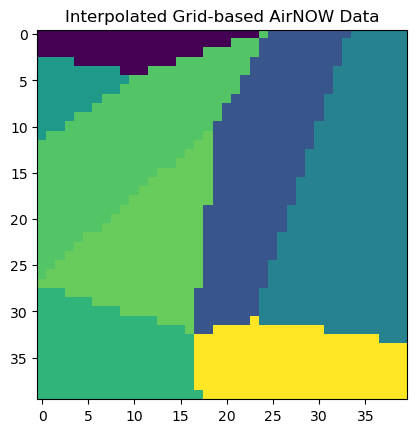

(40, 40)


In [12]:
inter = interpolate_frame(unInter, dim)

plt.imshow(inter)
plt.title("Interpolated Grid-based AirNOW Data")
plt.show()

# Scale

In [7]:
scaled_samples = (inter - inter.mean()) / np.std(inter)

In [9]:
n_samples, n_frames, n_channels = 1, 1, 2
payload = np.zeros((n_samples, n_frames, dim, dim, n_channels))
payload[0, 0, :, :, 0] = scaled_samples
# payload[0, 0, :, :, 1] = scaled_hrrr ??
# also guessing that since this is from the inference script, shape will be (1, 1, 40, 40, 2); 1 sample, 1 frame (is not 5?), 40x40, 2 channels